##EXPLORING AUDIO ONSET DETECTION WITH MACHINE LEARNING 

This  work  aims  to  further  explore  the  task  of  Audio  Onset Detection with deep learning, presenting a novel Convolutional  Recurrent  Neural  Network  (CRNN)  for  Musical Onset  Detection.  In  particular, the proposed  architecture has been trained with different hyper-parameter tuning and CNN kernel filters size in order to find the best combination of parameters in terms of performances. Two different dataset have been used for the scope of the project, *Leveau* dataset [1] and the merge of it with *Holzapfel* dataset [2].The model has been been trained with two different input, **spectrogram**  and **log-normalized  Mel  Band  spectrogram**. 

[1]: http://www.tsi.telecom-paristech.fr/aao/en/2011/07/13/onset_leveau-a-database-for-onset-detection/
[2]: Holzapfel, André, et al. "Three dimensions of pitched instrument onset detection." IEEE Transactions on Audio, Speech, and Language Processing 18.6 (2009): 1517-1527.

## DATASET USED IN THIS NOTEBOOK

This notebook reports the CRNN architectures and the dataset used considering **Leveu** dataset and **log-normalized Mel Band spectrogram** input (32 Mel Band have been considered)

Please, go through the notebook carefully to change paths according to you own directories. 

The notebook is divided in two sections: 
- Extraction of features (magnitude and phase for the spectrogram)
- Neural Network: 
  - Squared Neural Network (kernel filter size: 3X3)
  - High Neural Network (kernel filter size: 2x6)
  - Wide Neural Network (kernel filter size: 6x2)

## Extraction of features

The following instruction will extract 32 Mel Band features from the audio file and the label which we will used for training and testing the networks as grund truth. 


First, lets make sure we are using Tensorflow 2.0 and we have a GPU available. 

In [0]:
#script to process data from prof dataset 
%tensorflow_version 2.x

In [50]:
import tensorflow
print(tensorflow.__version__)

2.2.0-rc2


Lets install all the modules we will need for this notebook 

In [51]:
!pip install essentia

Are the data are saved inside a Google Drive folder. Change it or remove it if your data are saved somewhere else. 

In [52]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Lets import all the modules we will need in the notebook and define directories path. Change the path according to your own directories. 

In [0]:
#lets define all the module and paths we will need
import os
import numpy as np
import scipy.io.wavfile as wav
from sklearn import preprocessing
from sklearn.externals import joblib
from numpy import genfromtxt
import matplotlib.pyplot as plt 
from essentia.standard import *
from scipy import signal
import essentia
import essentia.streaming

#dataset base folder path
dataset_folder = os.path.join('drive/My Drive/dataset_MIR/leveau/')
#audio file folder path
wav_path = dataset_folder + 'wav_files/'
#log-mel spectrogram folder path (the spectrogram will be saved inside this folder)
spect_path = dataset_folder + 'log_mel_spectogram/'
#spectrogram normalized folder path (the normalized spectrogram will be saved inside this folder)
norm_folder_path = dataset_folder + 'log_mel_spectogram_norm/'
#file for weight normalization 
normalized_features_wts_file = dataset_folder  + 'logmel_spect_wts'
#label folder path (the label extracted will be saved inside this folder)
label_path = dataset_folder + 'labels/'
#txt label file folder path 
txt_path = dataset_folder + 'txt_files/'

Lets define some variable and data we wil need in the following instructions.

In [54]:
eps = np.spacing(np.float(1e-16))
#window length
win_len = 512
#hop size length
hop_len = 256
#FFT 
nfft = 512
#sample rate
fs = 44100
#max length considered for the audio file
aud_max_len_samples = 15 * fs  # longest file 20 seconds not considering all the files longer than 20 seconds
#max number of frames
max_frames = int(np.ceil((aud_max_len_samples - win_len) / float(hop_len)))
#max number of frames
print("Max number of frames in a file: {}".format(max_frames))
#frame resolution
frame_res = fs / float(hop_len)


Max number of frames in a file: 2582


Lets define all the functions we will need for the extraction of the coefficient of the 32 Mel Band log normalized spectrograms

In [0]:
#function to create folder
def create_folder(folder_name):
    '''
    The function create a folder (if it already does not exist) with the name specified as input parameter into the current path
    Parameters:
    -----------
        :folder_name: name of the folder
    '''
    if not os.path.exists(folder_name):
        print('{} folder does not exist, creating it.'.format(folder_name))
        os.makedirs(folder_name)

In [0]:
def load_audio(audio_path):
    '''
    The function _load_audio loads an audio file into an array.
    If the exceeds the length of maximum samples, it get re-size to the maximum samples length,
    otherwise it is zero padded.
    Parameters:
    ------------
        :audio_path: the path where the file is saved
    Returns:
    ----------
        :tuple containing array of audio sampled (audio) and sampling frequency (fs)
    '''
    audio = loader = essentia.standard.MonoLoader(filename=audio_path)

    audio = loader()
    audio = audio / 32768.0 + eps  # maxim integer and bit coding
    #print('after', audio)
    audio = audio.reshape(audio.shape[0], 1)
    if audio.shape[0] < aud_max_len_samples:
         zero_pad = np.zeros((aud_max_len_samples - audio.shape[0], audio.shape[1]))
         audio = np.vstack((audio, zero_pad))
    elif audio.shape[0] > aud_max_len_samples:
         audio = audio[:aud_max_len_samples, :]
    return audio

In [0]:
def mel_spectrogram(audio_in):
    '''
    The function extracts the spectrogram of the audio file given as input parameter
    Parameters:
    -----------
    :audio_in: audio samples
    '''
    w = Windowing(type = 'hann')
    spectrum = Spectrum()  # FFT() would return the complex FFT, here we just want the magnitude spectrum
    mfcc = MFCC(numberBands = 32)
    logNorm = UnaryOperator(type='log')


    mfccs = []
    melbands = []
    melbands_log = []

    for frame in FrameGenerator(audio_in[:,0], frameSize=win_len, hopSize=hop_len, startFromZero=True):
      mfcc_bands, mfcc_coeffs = mfcc(spectrum(w(frame)))
      mfccs.append(mfcc_coeffs)
      melbands.append(mfcc_bands)
      melbands_log.append(logNorm(mfcc_bands))

    melbands_log = melbands_log[:max_frames]  
    print(len(melbands_log))

      # transpose to have it in a better shape
      # we need to convert the list to an essentia.array first (== numpy.array of floats)

    mfccs = essentia.array(mfccs).T   
    melbands = essentia.array(melbands).T
    melbands_log = essentia.array(melbands_log).T


    imshow(melbands_log[:,:], aspect = 'auto', origin='lower', interpolation='none')
    plt.title("Log-normalized mel band spectral energies in frames")
    show()

    print("Log_normalize mel band spectral energies in frames: ", melbands_log.shape)

    return melbands_log.T

In [0]:
def extract_mel_spectogram(audio_filename, file, file_count, spect_path):
    '''
    The function handle the extraction of the spectrogram of the input file and save in in the feature directory
    Parameters:
    -----------
        :audio_filename: the name of the file for which the spectrogram is extracted
    '''

    audio_in = load_audio(audio_filename)

    spec = mel_spectrogram(audio_in)

    file_name = audio_filename.split('/')[-1]
    path = spect_path + file_name
    print("Saving file {0} with shape {1}".format(audio_filename, spec.shape))
    np.save(path, spec)
    print("Saving file {0} with shape {1}".format(audio_filename, spec.shape))
    print("Log-spectogram file {0} saved in {1}".format(audio_filename, path))
    

    return spec

In [0]:
#@title
#normalization of feature 
def normalize_feature(spect_path, normalized_features_wts_file, norm_folder_path):
    '''
    The function normalize the features, calculating thr weight on the training test and applying the transofrmation to all the dataset. 
    Input parameters:
    --------------------
    :spect_path: spectrogram path 
    :normalized features_wts_file: file where the weights will be saved
    :norm_fodler_path: normalized spectrogram folder path 
    '''

    spec_scaler = preprocessing.StandardScaler()
    train_cnt = 0

    for file_cnt, file_name in enumerate(os.listdir(spect_path)):
        if 'training_' in file_name and file_name != '.DS_Store':
            print(file_cnt, train_cnt, file_name)
            feat_file = np.load(os.path.join(spect_path, file_name))
            spec_scaler.partial_fit(feat_file)
            del feat_file
            train_cnt += 1
            # check point, saving the feature scaling (normalization) to a file on a disk

    joblib.dump(
        spec_scaler,
        normalized_features_wts_file
    )
    print("Weighthed count on {} training file".format(train_cnt))

    print('Normalizing feature files')
    for file_cnt, file_name in enumerate(os.listdir(spect_path)):
        if file_name != '.DS_Store':
            print(file_cnt, file_name)
            feat_file = np.load(os.path.join(spect_path, file_name))
            feat_file = spec_scaler.transform(feat_file)
            print("Feature file shape: {}".format(feat_file.shape))
            np.save(
                os.path.join(norm_folder_path, file_name),
                feat_file
            )
            del feat_file

    print('normalized files written to {} folder and the scaler to {}'.format(
        norm_folder_path, normalized_features_wts_file))

    print("Normalized {} files ".format(file_cnt))

In [0]:
#function to read txt file and extract the labels
def read_desc_file(file_name):
  '''
  The function extract the label from the csv file and save them inside the array labels.
  Parameters:
  ---------------
  Input:
  :file_name: the path of the file where to extract thr label from
  Output
  :labels: label array to return
  '''
  labels = genfromtxt(file_name, delimiter=',')
  return labels

In [0]:
#function to extract the label from file and save them inside the se_label. 
def get_labels_for_file(desc_file):
  '''
  The function saved all the label inside the array se_label. 
  For each label extracted from the desc_file, it is calculated the frame where the onset is active and saved as 1 in the array se_label. 
  Input paramaters:
  ----------------------
  :desc_file: label file for the audio file considered
  Return:
  -----------
  se_label: array describing the audio file where 1 means onset present on the frame and 0 means no audio onset present in the audio file
  '''
  onset_array = []
  se_label = np.zeros(max_frames)
  for i in range(len(desc_file)):
    onset_frame = int(np.floor(float(desc_file[i]) * frame_res))
    if onset_frame < max_frames:
      onset_array.append(onset_frame)
      se_label[onset_frame] = 1

  return se_label

Now, lets have a look at the list of file we are going to use in this notebook. 

In [62]:
#@title
file_count = 0
print("File that will be processed: ")
for file in os.listdir(wav_path):
    if not file.startswith('.'):
        print(file)
        file_count += 1

print("Total number of file in dataset: {}".format(file_count))

File that will be processed: 
training_synthbass1.wav
training_distguit1.wav
training_techno2.wav
test_jazz3.wav
test_guitar3.wav
training_violin2.wav
training_sax1.wav
training_cello1.wav
training_rock1.wav
training_pop1.wav
training_piano1.wav
training_trumpet1.wav
training_guitar2.wav
training_classic2.wav
test_classic3.wav
training_jazz2.wav
Total number of file in dataset: 16


2582


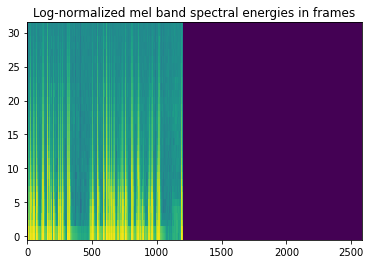

Log_normalize mel band spectral energies in frames:  (32, 2582)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/training_synthbass1.wav with shape (2582, 32)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/training_synthbass1.wav with shape (2582, 32)
Log-spectogram file drive/My Drive/dataset_MIR/leveau/wav_files/training_synthbass1.wav saved in drive/My Drive/dataset_MIR/leveau/log_mel_spectogram/training_synthbass1.wav
2582


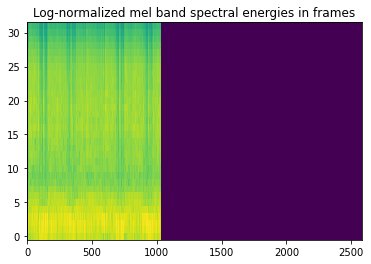

Log_normalize mel band spectral energies in frames:  (32, 2582)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/training_distguit1.wav with shape (2582, 32)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/training_distguit1.wav with shape (2582, 32)
Log-spectogram file drive/My Drive/dataset_MIR/leveau/wav_files/training_distguit1.wav saved in drive/My Drive/dataset_MIR/leveau/log_mel_spectogram/training_distguit1.wav
2582


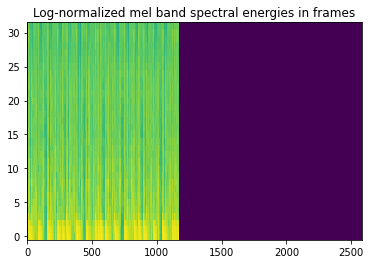

Log_normalize mel band spectral energies in frames:  (32, 2582)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/training_techno2.wav with shape (2582, 32)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/training_techno2.wav with shape (2582, 32)
Log-spectogram file drive/My Drive/dataset_MIR/leveau/wav_files/training_techno2.wav saved in drive/My Drive/dataset_MIR/leveau/log_mel_spectogram/training_techno2.wav
2582


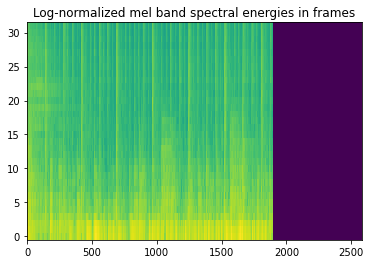

Log_normalize mel band spectral energies in frames:  (32, 2582)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/test_jazz3.wav with shape (2582, 32)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/test_jazz3.wav with shape (2582, 32)
Log-spectogram file drive/My Drive/dataset_MIR/leveau/wav_files/test_jazz3.wav saved in drive/My Drive/dataset_MIR/leveau/log_mel_spectogram/test_jazz3.wav
2582


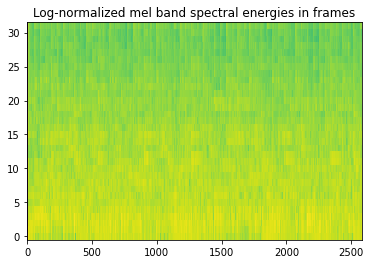

Log_normalize mel band spectral energies in frames:  (32, 2582)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/test_guitar3.wav with shape (2582, 32)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/test_guitar3.wav with shape (2582, 32)
Log-spectogram file drive/My Drive/dataset_MIR/leveau/wav_files/test_guitar3.wav saved in drive/My Drive/dataset_MIR/leveau/log_mel_spectogram/test_guitar3.wav
2582


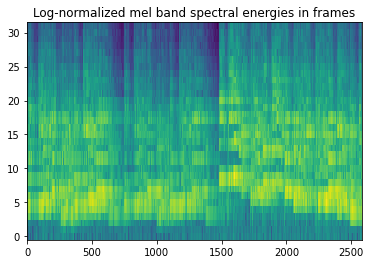

Log_normalize mel band spectral energies in frames:  (32, 2582)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/training_violin2.wav with shape (2582, 32)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/training_violin2.wav with shape (2582, 32)
Log-spectogram file drive/My Drive/dataset_MIR/leveau/wav_files/training_violin2.wav saved in drive/My Drive/dataset_MIR/leveau/log_mel_spectogram/training_violin2.wav
2582


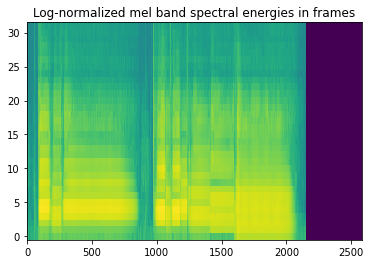

Log_normalize mel band spectral energies in frames:  (32, 2582)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/training_sax1.wav with shape (2582, 32)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/training_sax1.wav with shape (2582, 32)
Log-spectogram file drive/My Drive/dataset_MIR/leveau/wav_files/training_sax1.wav saved in drive/My Drive/dataset_MIR/leveau/log_mel_spectogram/training_sax1.wav
2582


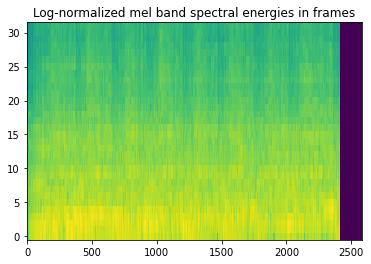

Log_normalize mel band spectral energies in frames:  (32, 2582)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/training_cello1.wav with shape (2582, 32)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/training_cello1.wav with shape (2582, 32)
Log-spectogram file drive/My Drive/dataset_MIR/leveau/wav_files/training_cello1.wav saved in drive/My Drive/dataset_MIR/leveau/log_mel_spectogram/training_cello1.wav
2582


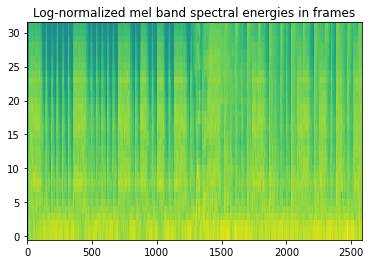

Log_normalize mel band spectral energies in frames:  (32, 2582)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/training_rock1.wav with shape (2582, 32)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/training_rock1.wav with shape (2582, 32)
Log-spectogram file drive/My Drive/dataset_MIR/leveau/wav_files/training_rock1.wav saved in drive/My Drive/dataset_MIR/leveau/log_mel_spectogram/training_rock1.wav
2582


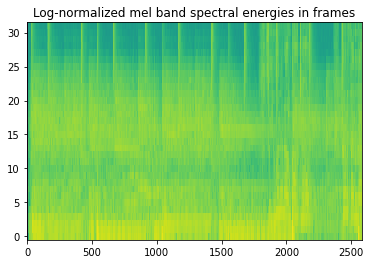

Log_normalize mel band spectral energies in frames:  (32, 2582)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/training_pop1.wav with shape (2582, 32)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/training_pop1.wav with shape (2582, 32)
Log-spectogram file drive/My Drive/dataset_MIR/leveau/wav_files/training_pop1.wav saved in drive/My Drive/dataset_MIR/leveau/log_mel_spectogram/training_pop1.wav
2582


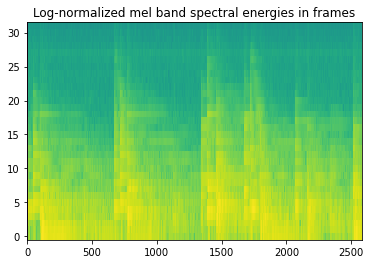

Log_normalize mel band spectral energies in frames:  (32, 2582)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/training_piano1.wav with shape (2582, 32)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/training_piano1.wav with shape (2582, 32)
Log-spectogram file drive/My Drive/dataset_MIR/leveau/wav_files/training_piano1.wav saved in drive/My Drive/dataset_MIR/leveau/log_mel_spectogram/training_piano1.wav
2582


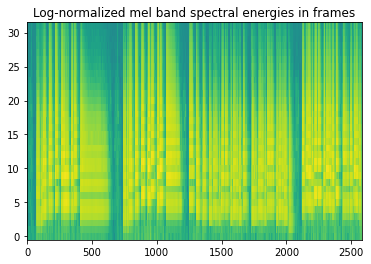

Log_normalize mel band spectral energies in frames:  (32, 2582)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/training_trumpet1.wav with shape (2582, 32)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/training_trumpet1.wav with shape (2582, 32)
Log-spectogram file drive/My Drive/dataset_MIR/leveau/wav_files/training_trumpet1.wav saved in drive/My Drive/dataset_MIR/leveau/log_mel_spectogram/training_trumpet1.wav
2582


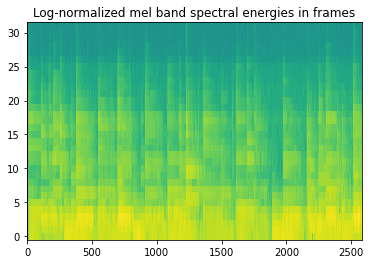

Log_normalize mel band spectral energies in frames:  (32, 2582)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/training_guitar2.wav with shape (2582, 32)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/training_guitar2.wav with shape (2582, 32)
Log-spectogram file drive/My Drive/dataset_MIR/leveau/wav_files/training_guitar2.wav saved in drive/My Drive/dataset_MIR/leveau/log_mel_spectogram/training_guitar2.wav
2582


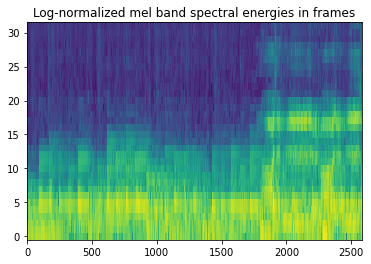

Log_normalize mel band spectral energies in frames:  (32, 2582)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/training_classic2.wav with shape (2582, 32)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/training_classic2.wav with shape (2582, 32)
Log-spectogram file drive/My Drive/dataset_MIR/leveau/wav_files/training_classic2.wav saved in drive/My Drive/dataset_MIR/leveau/log_mel_spectogram/training_classic2.wav
2582


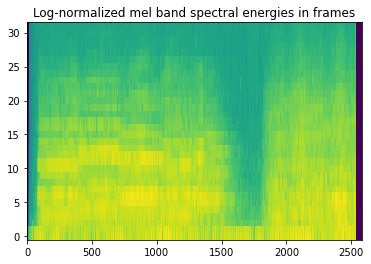

Log_normalize mel band spectral energies in frames:  (32, 2582)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/test_classic3.wav with shape (2582, 32)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/test_classic3.wav with shape (2582, 32)
Log-spectogram file drive/My Drive/dataset_MIR/leveau/wav_files/test_classic3.wav saved in drive/My Drive/dataset_MIR/leveau/log_mel_spectogram/test_classic3.wav
2582


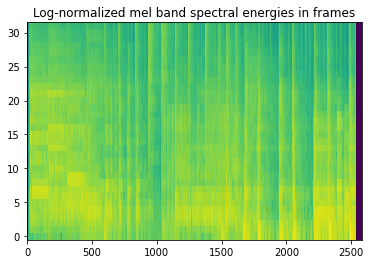

Log_normalize mel band spectral energies in frames:  (32, 2582)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/training_jazz2.wav with shape (2582, 32)
Saving file drive/My Drive/dataset_MIR/leveau/wav_files/training_jazz2.wav with shape (2582, 32)
Log-spectogram file drive/My Drive/dataset_MIR/leveau/wav_files/training_jazz2.wav saved in drive/My Drive/dataset_MIR/leveau/log_mel_spectogram/training_jazz2.wav
File processed: 16


In [63]:
from pylab import plot, show, figure, imshow
%matplotlib inline
import matplotlib.pyplot as pl

file_count = 0
#the dataset will be divided anyway in 12 files which will be served for training set and 4 which will be used as test set.
create_folder(spect_path)
create_folder(norm_folder_path)
create_folder(label_path)

#extracting spectogram for each file
for filename in os.listdir(wav_path):
    if not filename.startswith('.'):
      file_path = os.path.join(wav_path, filename)
      extract_mel_spectogram(file_path, filename, file_count, spect_path)

      file_count += 1

print("File processed: {}".format(file_count))

In [0]:
#normalizing feature for each filecf
normalize_feature(spect_path, normalized_features_wts_file, norm_folder_path)

0 0 training_synthbass1.wav.npy
1 1 training_distguit1.wav.npy
2 2 training_techno2.wav.npy
5 3 training_violin2.wav.npy
6 4 training_sax1.wav.npy
7 5 training_cello1.wav.npy
8 6 training_rock1.wav.npy
9 7 training_pop1.wav.npy
10 8 training_piano1.wav.npy
11 9 training_trumpet1.wav.npy
12 10 training_guitar2.wav.npy
13 11 training_classic2.wav.npy
15 12 training_jazz2.wav.npy
Weighthed count on 13 training file
Normalizing feature files
0 training_synthbass1.wav.npy
Feature file shape: (2582, 32)
1 training_distguit1.wav.npy
Feature file shape: (2582, 32)
2 training_techno2.wav.npy
Feature file shape: (2582, 32)
3 test_jazz3.wav.npy
Feature file shape: (2582, 32)
4 test_guitar3.wav.npy
Feature file shape: (2582, 32)
5 training_violin2.wav.npy
Feature file shape: (2582, 32)
6 training_sax1.wav.npy
Feature file shape: (2582, 32)
7 training_cello1.wav.npy
Feature file shape: (2582, 32)
8 training_rock1.wav.npy
Feature file shape: (2582, 32)
9 training_pop1.wav.npy
Feature file shape: (25

In [0]:
#@title
#label extraction
print(os.listdir(txt_path))
for file_cnt, file_name in enumerate(os.listdir(txt_path)):
  if file_name != '.DS_Store':
    print('file_cnt {}, file_name {}'.format(file_cnt, file_name))
    desc_file = read_desc_file(os.path.join(txt_path, file_name))
    #giving the same name extension to the file in order to make easier the processing of the file in the future instructions
    wav_filename = '{}.wav'.format(file_name.split('.')[0])
    labels = get_labels_for_file(desc_file)
    #reshape of the file to be processed correctly for the networks
    labels = labels.reshape(labels.shape[0], 1)
    print("Label file shape: {}".format(labels.shape))
    np.save(os.path.join(label_path, wav_filename), labels)

print("File which have been processed: ", file_cnt)

['training_pop1.csv', 'training_trumpet1.csv', 'training_cello1.csv', 'training_rock1.csv', 'training_guitar2.csv', 'training_piano1.csv', 'training_classic2.csv', 'training_sax1.csv', 'test_classic3.csv', 'training_synthbass1.csv', 'test_jazz3.csv', 'training_jazz2.csv', 'training_violin2.csv', 'test_guitar3.csv', 'training_distguit1.csv', 'training_techno2.csv']
file_cnt 0, file_name training_pop1.csv
drive/My Drive/dataset_MIR/leveau/txt_files/training_pop1.csv
Label file shape: (2582, 1)
file_cnt 1, file_name training_trumpet1.csv
drive/My Drive/dataset_MIR/leveau/txt_files/training_trumpet1.csv
Label file shape: (2582, 1)
file_cnt 2, file_name training_cello1.csv
drive/My Drive/dataset_MIR/leveau/txt_files/training_cello1.csv
Label file shape: (2582, 1)
file_cnt 3, file_name training_rock1.csv
drive/My Drive/dataset_MIR/leveau/txt_files/training_rock1.csv
Label file shape: (2582, 1)
file_cnt 4, file_name training_guitar2.csv
drive/My Drive/dataset_MIR/leveau/txt_files/training_gui

## Neural Network - Training and Evaluation

In this part of the code, the different CRNN architectures will be trained and evaluate. In particular, we are going to train three different CRNN hyper-paramater: 
- Squared (kernel filter 3x3)
- High (kernel filter 6x2)
- Wide (kernel filter 2x6)


Each of them used different kernel filter size and each of them will be trained with different combination of batch size and sequence lenght in order to find the combination which give the best performance. 
The network will be evaluated in terms of accurcay and F1-score and the relatives confusion matrices will be printed. 

### Definition of hyper-parameter

CRNN - In the next sections we will define the hyper-paramater which will be used in ecah different network which we will train and evaluate (such as CNN units, RNN units, FC units, etc.) together with teh generator of the training batches and functions to collect ground truth labels. 
Detail of the network can be found in the report LINK TO REPORT 

In [0]:
#collection of the ground truth label for the test dataset
def collect_test_labels(_data_gen_test, _data_out, quick_test):
     '''
     The function collect the label for the ground truth. 
     Input parameters: 
      ---------------------
      :_data_gen_test: generator for the test dataset
      : _data_out: data output
      : quick_test: 1 for quick test, 0 for no quick test
      Return:
      ------------
      gruund truth label
     '''

     nb_batch = 1 if quick_test else _data_gen_test.get_total_batches_in_data()
     batch_size = _data_out[0]
     gt_sed = np.zeros((nb_batch * batch_size, _data_out[1], _data_out[2]))
     cnt = 0
     for tmp_feat, tmp_label in _data_gen_test.generate():
         gt_sed[cnt * batch_size:(cnt + 1) * batch_size, :, :] = tmp_label[0]
         cnt = cnt + 1
         if cnt == nb_batch:
             break
     return gt_sed.astype(int)

Definition of hyper-parameter used in the network. 
Please consider that nb_epochs, sequence length and batch size we will now be set to 1 but they will be changed in the following instructions. 
Different combinations well be used in order to find the best performance combinations, which in the future will be set in this dictionary as well. Right now they are only defined for the future and set to 1. 

In [0]:
# Parameters used in the feature extraction, neural network model, and training the CRNN network can be changed here.

#function to get parameters for the model
def get_params():
    '''
    Return:
    --------
        :params: dictionary with parameters specified according to dataset and training model
    '''
    # ########### default parameters ##############
    params = dict(
        quick_test=False,    # To do quick test. Trains/test on small subset of dataset
        nfft=512,          # FFT/window length size
        # DNN Model parameters
        sequence_length=1,           # Feature sequence length
        batch_size=1,               # Batch size 
        dropout_rate=0.0,           # Dropout rate, constant for all layers
        nb_cnn2d_filt=64,           # Number of CNN nodes, constant for each layer
        pool_size=[2, 2, 2],        # CNN pooling, length of list = number of CNN layers, list value = pooling per layer
        rnn_size=[128, 128],        # RNN contents, length of list = number of layers, list value = number of nodes
        fnn_size=[128],             # FNN contents, length of list = number of layers, list value = number of nodes
        loss_weights=[1.],          # weights
        nb_epochs=1,                # Train for maximum epochs (one forward pass and one backward pass for all training examples)
                                  
    )

    for key, value in params.items():
        print("{}: {}".format(key, value))
    return params


In [0]:
# Data generator for training batch size 

import numpy as np
from numpy.random import seed
seed(1)
import os
from IPython import embed
from collections import deque
import random


class DataGenerator(object):
    def __init__(
            self, datagen_mode='train', batch_size=4, seq_len=216,
            shuffle=True, nfft=512, extra_name=''
    ):

        self._datagen_mode = datagen_mode
        self._batch_size = batch_size
        self._seq_len = seq_len
        self._shuffle = shuffle
        self._label_dir = os.path.join(dataset_folder, 'labels')
        self._feat_dir = os.path.join(dataset_folder, 'Spect_norma')

        self._filenames_list = list()
        self._nb_frames_file = None                   # Assuming number of frames in feat files are the same
        self._feat_len = None
        self._nb_ch = 2                               #(multiply per due )
        self._label_len = None                        
        self._nb_classes = 1
        self._get_label_filenames_sizes()


        self._batch_seq_len = self._batch_size*self._seq_len
        self._circ_buf_feat = None
        self._circ_buf_label = None


        self._nb_total_batches = int(np.floor((len(self._filenames_list) * self._nb_frames_file /
                                               float(self._seq_len * self._batch_size))))

    #function to get labels shapes and features shape
    def get_data_sizes(self):
        '''
        Function to retrieve information regarding features shape and label shape.
        Returns:
        --------
            : feat_shape and label_shape, tuple and list of of label and features shapes
        '''
        #features shape
        feat_shape = (self._batch_size, self._nb_ch, self._seq_len, int(self._feat_len))
        #first label for class
        label_shape = (self._batch_size, self._seq_len, self._nb_classes)

        return feat_shape, label_shape

    #function to get total number of batches in data
    def get_total_batches_in_data(self):
        '''
        Function to the total number of batches
        Return:
        --------
            : total number of batches
        '''
        print("Total number of batches in {}: {}".format(self._datagen_mode, self._nb_total_batches))
        return self._nb_total_batches

    #function to get information according to the dataset
    def _get_label_filenames_sizes(self):
        '''
        The function retrieves all the file belonging to the specified dataset type
        '''
        training_file_count = 0

        for filename in os.listdir(self._label_dir):
            if self._datagen_mode in filename:
                training_file_count += 1
                self._filenames_list.append(filename)

        temp_feat = np.load(os.path.join(self._feat_dir, self._filenames_list[0]))

        #number of frames per file and features length
        self._nb_frames_file = temp_feat.shape[0]
        self._feat_len = temp_feat.shape[1] / self._nb_ch
      
        temp_label = np.load(os.path.join(self._label_dir, self._filenames_list[0]))
        #label length 
        self._label_len = temp_label.shape[-1]
    
        return

    #genearator
    def generate(self):
        """
        Generates batches of samples
        :return:
        """

        while 1:
            if self._shuffle:
                random.shuffle(self._filenames_list)

            # Ideally this should have been outside the while loop. But while generating the test data we want the data
            # to be the same exactly for all epoch's hence we keep it here.
            self._circ_buf_feat = deque()
            self._circ_buf_label = deque()

            file_cnt = 0

            for i in range(self._nb_total_batches):

                # load feat and label to circular buffer. Always maintain at least one batch worth feat and label in the
                # circular buffer. If not keep refilling it.
                
                #creation of the batches.
                while len(self._circ_buf_feat) < self._batch_seq_len:


                    temp_feat = np.load(os.path.join(self._feat_dir, self._filenames_list[file_cnt]))
                    temp_label = np.load(os.path.join(self._label_dir, self._filenames_list[file_cnt]))


                    for row_cnt, row in enumerate(temp_feat):

                        self._circ_buf_feat.append(row)
                        self._circ_buf_label.append(temp_label[row_cnt])

                    file_cnt = file_cnt + 1

                # Read one batch size from the circular buffer
                feat = np.zeros((self._batch_seq_len, int(self._feat_len) * self._nb_ch))
                label = np.zeros((self._batch_seq_len, self._label_len))

                for j in range(self._batch_seq_len):
                    feat[j, :] = self._circ_buf_feat.popleft()
                    label[j, :] = self._circ_buf_label.popleft()
                feat = np.reshape(feat, (self._batch_seq_len, int(self._feat_len), self._nb_ch))


                # Split to sequences
                # making the data the same dimensions as the labels and the features
                feat = self._split_in_seqs(feat)
                label = self._split_in_seqs(label)

                yield feat, label

    def _split_in_seqs(self, data):
        if len(data.shape) == 1:
            if data.shape[0] % self._seq_len:
                data = data[:-(data.shape[0] % self._seq_len), :]
            data = data.reshape((int(data.shape[0] / self._seq_len), self._seq_len, 1))
        elif len(data.shape) == 2:
            if data.shape[0] % self._seq_len:
                data = data[:-(data.shape[0] % self._seq_len), :]
            data = data.reshape((int(data.shape[0] / self._seq_len), self._seq_len, data.shape[1]))
        elif len(data.shape) == 3:
            if data.shape[0] % self._seq_len:
                data = data[:-(data.shape[0] % self._seq_len), :, :]
            data = data.reshape((int(data.shape[0] / self._seq_len), self._seq_len, data.shape[1], data.shape[2]))
        else:
            print('ERROR: Unknown data dimensions: {}'.format(data.shape))
            exit()
        return data

In [0]:
#label reshape
def reshape_3Dto2D(A):
    return A.reshape(A.shape[0] * A.shape[1], A.shape[2])


In [68]:
params = get_params()

quick_test: False
nfft: 512
sequence_length: 1
batch_size: 1
dropout_rate: 0.0
nb_cnn2d_filt: 64
pool_size: [2, 2, 2]
rnn_size: [128, 128]
fnn_size: [128]
loss_weights: [1.0]
nb_epochs: 1


In [0]:
#lets create the folder where all the predictions will be saved
prediction_folder = dataset_folder + 'predictions/'
label_for_prediction_folder = dataset_folder + 'prediction_labels/'
create_folder(prediction_folder)
create_folder(label_for_prediction_folder)

## Squared CRNN architecture, kernel filter size 3x3

In [0]:
#lets create the folder for the squared predictions
squared_pred_path = prediction_folder + 'squared_pred/'
squared_pred_lab_path = label_for_prediction_folder + 'squared_pred_lab/'
create_folder(squared_pred_path)
create_folder(squared_pred_lab_path)

In [0]:
from numpy.random import seed
seed(1)
import tensorflow as ts
from tensorflow.keras.layers import Bidirectional, Conv2D, MaxPool2D, Input, MaxPooling3D, Conv3D
from tensorflow.keras.layers import Dense, Activation, Dropout, Reshape, Permute
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.optimizers import Adam

ts.keras.backend.set_image_data_format('channels_last')

def get_model_squared(data_in, data_out, dropout_rate, nb_cnn2d_filt, pool_size,
              rnn_size, fnn_size, weights, first):

    #initial dimension set for channel last
    spec_start = Input(shape=(data_in[2], data_in[3], data_in[1]))
    #dimension for cnn same as the starting point
    spec_cnn = spec_start
    for i, convCount in enumerate(pool_size):
        #convolutional layer with squared kernel size
        spec_cnn = Conv2D(filters=nb_cnn2d_filt, kernel_size=(3, 3), padding='same')(spec_cnn)
        spec_cnn = BatchNormalization(trainable=True)(spec_cnn, training=True)
        spec_cnn = Activation('relu')(spec_cnn)
        spec_cnn = MaxPool2D(pool_size=(1, pool_size[i]))(spec_cnn)

    #reshape to a proper dimension for recurrent layers
    spec_rnn = Reshape((data_in[2], 2*nb_cnn2d_filt))(spec_cnn)

    for nb_rnn_filt in rnn_size:
        spec_rnn = Bidirectional(
            GRU(nb_rnn_filt, activation='tanh', dropout=dropout_rate, recurrent_dropout=dropout_rate,
                return_sequences=True, reset_after=False), 
            merge_mode='mul'
        )(spec_rnn, training=True)

    sed = spec_rnn
    sed = TimeDistributed(Dense(fnn_size[0]))(sed)
    sed = TimeDistributed(Dense(data_out[-1]))(sed)
    sed = Activation('sigmoid', name='sed_out')(sed)

    model = Model(inputs=spec_start, outputs=[sed])
    model.compile(optimizer=Adam(), loss=['binary_crossentropy'], loss_weights=weights)

    if first:
      model.summary()
    return model

In [73]:
import numpy as np
from numpy.random import seed
seed(1)
import sys
import os
import time
import matplotlib.pyplot as plot
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# get all the parameters i need for the project
nb_epochs = 25 #if changed all the prediction need to be re-done so please delete the file inside the folders and start the code again. 
first = 1


#loop trough the different epochs, sequence lenghth and batch size:
for seq_lenght in [256, 128, 64]:
  for batch_size in [16, 8, 4]:
    
    params['sequence_length'] = seq_lenght
    params['batch_size'] = batch_size
    params['nb_epochs'] = nb_epochs
    
    print('-------------------------------------------')
    
    print("Batch size: ", batch_size)
    print("seq_lenght: ", seq_lenght)
    pred_filename = '/pred_{}_{}'.format(batch_size, seq_lenght)
    #if the prediction is already done, skip it. Please, consider to delete the file if the number of epochs is changed 
    if os.path.exists(os.path.join(squared_pred_path + pred_filename + '.npy')):
      print("Prediction for batch size {0} and seq lenght {1} with squared filters already done".format(batch_size, seq_lenght))
    else:

      print("Path to file: ", os.path.join(squared_pred_path + pred_filename))

      data_gen_train = DataGenerator(
          nfft=params['nfft'],
          batch_size=params['batch_size'], seq_len=params['sequence_length'], datagen_mode='train'
      )


    # generation of testing dataset
      data_gen_test = DataGenerator(
         nfft=params['nfft'],
         batch_size=params['batch_size'], seq_len=params['sequence_length'], datagen_mode='test', shuffle=False
      )

      data_in, data_out = data_gen_train.get_data_sizes()
      print(data_in, data_out)

      model = get_model_squared(data_in=data_in, data_out=data_out, dropout_rate=params['dropout_rate'],
                  nb_cnn2d_filt=params['nb_cnn2d_filt'], pool_size=params['pool_size'],
                  rnn_size=params['rnn_size'], fnn_size=params['fnn_size'],
                  weights=params['loss_weights'], first=first)
    
      #so we do print the model only for the first case 
      first = 0

      gt = collect_test_labels(data_gen_test, data_out, params['quick_test'])
      #reshape to 2D
      sed_gt = reshape_3Dto2D(gt)
      file_path = os.path.join(squared_pred_lab_path + pred_filename + '_lab')
      print("File prediction saved: {}".format(file_path))
      np.save(file_path, sed_gt)
      print("File prediction saved: {}".format(file_path))

     # it returns an history value
     #model fit
      hist = model.fit(
          x=data_gen_train.generate(),
          steps_per_epoch=1 if params['quick_test'] else data_gen_train.get_total_batches_in_data(),
          validation_data=data_gen_test.generate(),
          validation_steps=1 if params['quick_test'] else data_gen_test.get_total_batches_in_data(),
          epochs=nb_epochs,
          verbose=1)

      #model predictions
      pred = model.predict(
          x=data_gen_test.generate(),
          steps=1 if params['quick_test'] else data_gen_test.get_total_batches_in_data(),
          verbose=0
      )
      
      #saving the files inside the prediction folder
      #training loss values
      hist_loss_filename = os.path.join(squared_pred_path + pred_filename) + '_hist_loss'
      np.save(hist_loss_filename, hist.history['loss'])
      print("File prediction loss saved {}".format(os.path.join(squared_pred_path + hist_loss_filename)))
      #validation loss values
      hist_val_loss_filename = os.path.join(squared_pred_path + pred_filename) + '_hist_val_loss'
      np.save(hist_val_loss_filename, hist.history['val_loss'])
      print("File prediction val_loss saved {}".format(os.path.join(squared_pred_path + hist_val_loss_filename))) 
      #prediction
      np.save(os.path.join(squared_pred_path + pred_filename), pred)
      print("File prediction saved {}".format(os.path.join(squared_pred_path + pred_filename)))

-------------------------------------------
Batch size:  16
seq_lenght:  256
Prediction for batch size 16 and seq lenght 256 with squared filters already done
-------------------------------------------
Batch size:  8
seq_lenght:  256
Prediction for batch size 8 and seq lenght 256 with squared filters already done
-------------------------------------------
Batch size:  4
seq_lenght:  256
Prediction for batch size 4 and seq lenght 256 with squared filters already done
-------------------------------------------
Batch size:  16
seq_lenght:  128
Prediction for batch size 16 and seq lenght 128 with squared filters already done
-------------------------------------------
Batch size:  8
seq_lenght:  128
Prediction for batch size 8 and seq lenght 128 with squared filters already done
-------------------------------------------
Batch size:  4
seq_lenght:  128
Prediction for batch size 4 and seq lenght 128 with squared filters already done
-------------------------------------------
Batch size

## Evaluation squared CRNN architecture

The network will be evaluated in terms of accurcay and F1-score

----------------------------------------
Prediction for batch size: 16, sequence lenght: 256
Accuracy:  0.999755859375
F1:  0.0


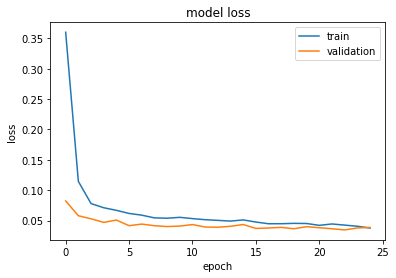

----------------------------------------
Prediction for batch size: 8, sequence lenght: 256
Accuracy:  0.9856770833333334
F1:  0.0


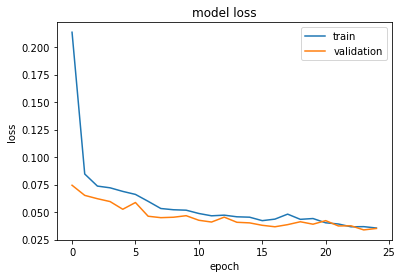

----------------------------------------
Prediction for batch size: 4, sequence lenght: 256
Accuracy:  0.9810267857142857
F1:  0.05555555555555555


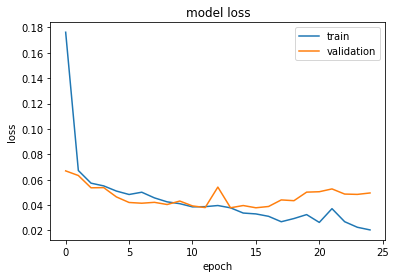

----------------------------------------
Prediction for batch size: 16, sequence lenght: 128
Accuracy:  0.9851888020833334
F1:  0.04210526315789474


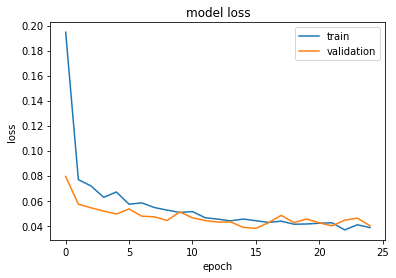

----------------------------------------
Prediction for batch size: 8, sequence lenght: 128
Accuracy:  0.9768415178571429
F1:  0.05681818181818182


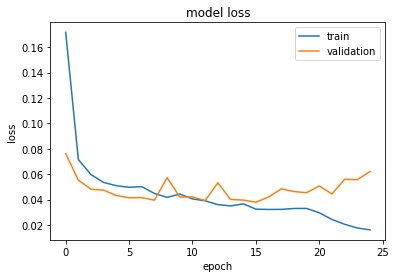

----------------------------------------
Prediction for batch size: 4, sequence lenght: 128
Accuracy:  0.981640625
F1:  0.06622516556291391


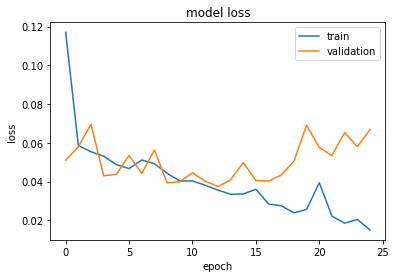

----------------------------------------
Prediction for batch size: 16, sequence lenght: 64
Accuracy:  0.9818638392857143
F1:  0.04411764705882353


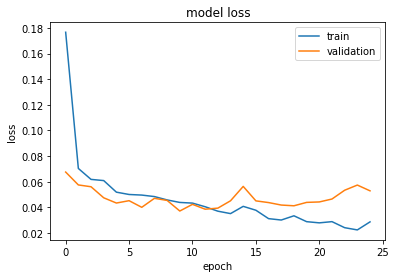

----------------------------------------
Prediction for batch size: 8, sequence lenght: 64
Accuracy:  0.9865885416666667
F1:  0.019047619047619046


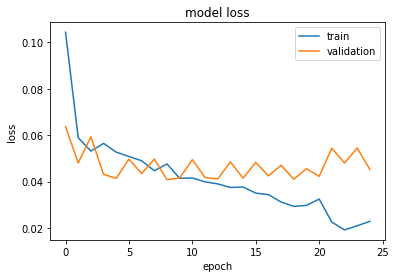

----------------------------------------
Prediction for batch size: 4, sequence lenght: 64
Accuracy:  0.9743489583333333
F1:  0.1085972850678733


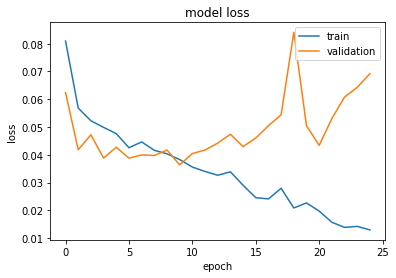

In [74]:
#we retrieve all the information from the files and plot the results in terms of accurcay and F1_score
import matplotlib.pyplot as plt


for filename in os.listdir(squared_pred_path):
  if (filename.split('.')[0].split('_')[-1]) != 'loss': 
    print('----------------------------------------')
    tmp_pred = np.load(os.path.join(squared_pred_path, filename))
    hist_path_loss = filename.split('.')[0] + '_hist_loss.npy'
    hist_path_val_loss = filename.split('.')[0] + '_hist_val_loss.npy'
    pred_path = filename.split('.')[0] + '_lab.npy'
    tmp_hist_loss = np.load(os.path.join(squared_pred_path, hist_path_loss))
    tmp_hist_val_loss = np.load(os.path.join(squared_pred_path, hist_path_val_loss))
    #thresholding
    tmp_pred_re = reshape_3Dto2D(tmp_pred) > 0.7
    sed_gt = np.load(os.path.join(squared_pred_lab_path, pred_path))
    
    print("Prediction for batch size: {}, sequence lenght: {}".format(filename.split('_')[1], filename.split('_')[2].split('.')[0]))

    accuracy = accuracy_score(sed_gt, tmp_pred_re)
    print("Accuracy: ", accuracy)

    f1 = f1_score(sed_gt, tmp_pred_re, zero_division=1)
    print("F1: ", f1)

    # summarize history for trainign and validation loss
    plt.plot(tmp_hist_loss)
    plt.plot(tmp_hist_val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

----------------------------------------
Prediction for batch size: 16, sequence lenght: 256
[[4095    1]
 [   0    0]]


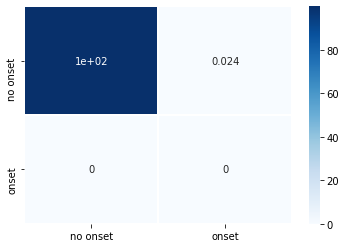

----------------------------------------
Prediction for batch size: 8, sequence lenght: 256
[[6056   16]
 [  72    0]]


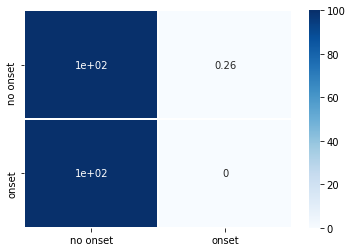

----------------------------------------
Prediction for batch size: 4, sequence lenght: 256
[[7028   40]
 [  96    4]]


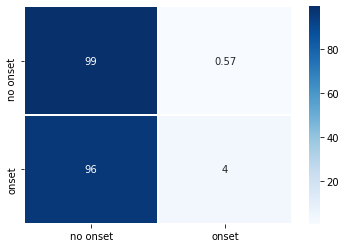

----------------------------------------
Prediction for batch size: 16, sequence lenght: 128
[[6051   13]
 [  78    2]]


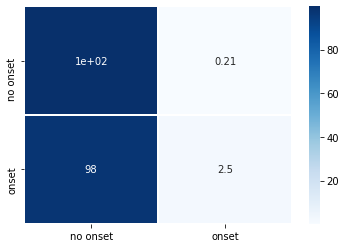

----------------------------------------
Prediction for batch size: 8, sequence lenght: 128
[[6997   67]
 [  99    5]]


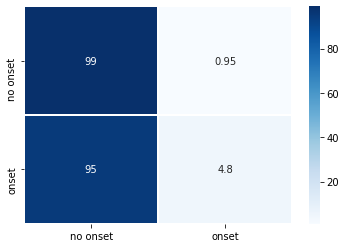

----------------------------------------
Prediction for batch size: 4, sequence lenght: 128
[[7534   46]
 [  95    5]]


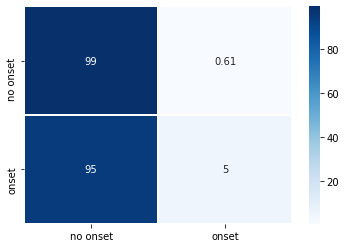

----------------------------------------
Prediction for batch size: 16, sequence lenght: 64
[[7035   21]
 [ 109    3]]


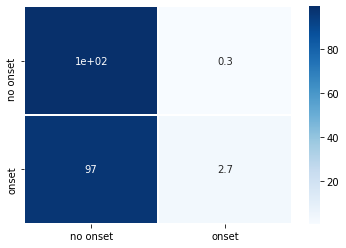

----------------------------------------
Prediction for batch size: 8, sequence lenght: 64
[[7576    8]
 [  95    1]]


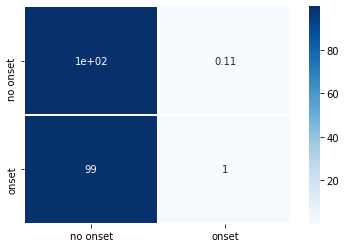

----------------------------------------
Prediction for batch size: 4, sequence lenght: 64
[[7471  101]
 [  96   12]]


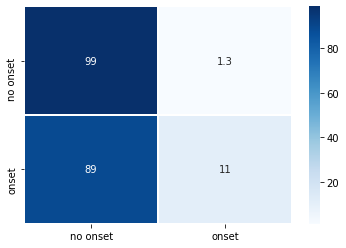

In [76]:
#we retrieve all the information from the files and plot the confusioon matrices
import matplotlib.pyplot as plt
import seaborn as sns


for filename in os.listdir(squared_pred_path):
  if (filename.split('.')[0].split('_')[-1]) != 'loss': 
    print('----------------------------------------')
    tmp_pred = np.load(os.path.join(squared_pred_path, filename))
    hist_path_loss = filename.split('.')[0] + '_hist_loss.npy'
    hist_path_val_loss = filename.split('.')[0] + '_hist_val_loss.npy'
    pred_path = filename.split('.')[0] + '_lab.npy'
    tmp_hist_loss = np.load(os.path.join(squared_pred_path, hist_path_loss))
    tmp_hist_val_loss = np.load(os.path.join(squared_pred_path, hist_path_val_loss))
    #thresholding
    tmp_pred_re = reshape_3Dto2D(tmp_pred) > 0.7
    sed_gt = np.load(os.path.join(squared_pred_lab_path, pred_path))
    
    print("Prediction for batch size: {}, sequence lenght: {}".format(filename.split('_')[1], filename.split('_')[2].split('.')[0]))

    matrix_test = confusion_matrix(sed_gt, tmp_pred_re)
    print(matrix_test) 

    matrix_test_norm = confusion_matrix(sed_gt, tmp_pred_re, normalize='true') * 100 

    ax = sns.heatmap(matrix_test_norm, linewidth=0.5, annot=True, cmap="Blues", xticklabels= ['no onset', 'onset'], yticklabels= ['no onset','onset'])
    plt.show() 

## High CRNN archictecture, kernel filter size 6x2

In [0]:
#lets craete the folder for the high prediction
high_pred_path = prediction_folder + 'high_pred'
high_pred_lab_path = label_for_prediction_folder + 'high_pred_lab'
create_folder(high_pred_path)
create_folder(high_pred_lab_path)

In [0]:
from numpy.random import seed
seed(1)
import tensorflow as ts
from tensorflow.keras.layers import Bidirectional, Conv2D, MaxPool2D, Input, MaxPooling3D, Conv3D
from tensorflow.keras.layers import Dense, Activation, Dropout, Reshape, Permute
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.optimizers import Adam

ts.keras.backend.set_image_data_format('channels_last')

def get_model_high(data_in, data_out, dropout_rate, nb_cnn2d_filt, pool_size,
              rnn_size, fnn_size, weights, first):

    #initial dimenison set for channel last
    spec_start = Input(shape=(data_in[2], data_in[3], data_in[1]))
    #dimension for cnn same as the starting point
    spec_cnn = spec_start
    for i, convCount in enumerate(pool_size):
        #convolutional layer - kernel filtr size 6x2
        spec_cnn = Conv2D(filters=nb_cnn2d_filt, kernel_size=(6, 2), padding='same')(spec_cnn)
        spec_cnn = BatchNormalization(trainable=True)(spec_cnn, training=True)
        spec_cnn = Activation('relu')(spec_cnn)
        spec_cnn = MaxPool2D(pool_size=(1, pool_size[i]))(spec_cnn)

    #reshape to a proper dimension for recurrent layers
    spec_rnn = Reshape((data_in[2], 2*nb_cnn2d_filt))(spec_cnn)
    for nb_rnn_filt in rnn_size:
        spec_rnn = Bidirectional(
            GRU(nb_rnn_filt, activation='tanh', dropout=dropout_rate, recurrent_dropout=dropout_rate,
                return_sequences=True, reset_after=False), #reset_after set to false to make it work, default value changed between the two versions
            merge_mode='mul'
        )(spec_rnn, training=True)

    #fc
    sed = spec_rnn
    sed = TimeDistributed(Dense(fnn_size[0]))(sed)
    sed = TimeDistributed(Dense(data_out[-1]))(sed)
    sed = Activation('sigmoid', name='sed_out')(sed)

    model = Model(inputs=spec_start, outputs=[sed])
    model.compile(optimizer=Adam(), loss=['binary_crossentropy'], loss_weights=weights)

    if first:
      model.summary()
    return model

In [79]:
import numpy as np
from numpy.random import seed
seed(1)
import sys
import os
import time
import matplotlib.pyplot as plot
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# get all the parameters i need for the project
nb_epochs = 25 #if changed all the prediction need to be re-done so please delete the file inside the folders and start the code again. 
first = 1


#loop trough the different epochs, sequence lenghth and batch size:
for seq_lenght in [256, 126, 64]:
  for batch_size in [16, 8, 4]:
    
    params['sequence_length'] = seq_lenght
    params['batch_size'] = batch_size
    params['nb_epochs'] = nb_epochs
    
    print('-------------------------------------------')
    
    print("Batch size: ", batch_size)
    print("seq_lenght: ", seq_lenght)
    pred_filename = '/pred_{}_{}'.format(batch_size, seq_lenght) 
    if os.path.exists(os.path.join(high_pred_path + pred_filename + '.npy')):
      print("Prediction for batch size {0} and seq lenght {1} with squared filters already done".format(batch_size, seq_lenght))
    else:

      print("Path to file: ", os.path.join(high_pred_path + pred_filename))

      data_gen_train = DataGenerator(
          nfft=params['nfft'],
          batch_size=params['batch_size'], seq_len=params['sequence_length'], datagen_mode='train'
      )


    # generation of testing dataset
      data_gen_test = DataGenerator(
         nfft=params['nfft'],
         batch_size=params['batch_size'], seq_len=params['sequence_length'], datagen_mode='test', shuffle=False
      )

      data_in, data_out = data_gen_train.get_data_sizes()

      model = get_model_high(data_in=data_in, data_out=data_out, dropout_rate=params['dropout_rate'],
                  nb_cnn2d_filt=params['nb_cnn2d_filt'], pool_size=params['pool_size'],
                  rnn_size=params['rnn_size'], fnn_size=params['fnn_size'],
                  weights=params['loss_weights'], first=first)
    
      #so we do print the model only for the first case 
      first = 0

      gt = collect_test_labels(data_gen_test, data_out, params['quick_test'])
      #reshape to 2D
      sed_gt = reshape_3Dto2D(gt)
      file_path = os.path.join(high_pred_lab_path + pred_filename + '_lab')
      print("File prediction saved: {}".format(file_path))
      np.save(file_path, sed_gt)
      print("File prediction saved: {}".format(file_path))


     # it returns an history value
     #model fit
      hist = model.fit(
          x=data_gen_train.generate(),
          steps_per_epoch=1 if params['quick_test'] else data_gen_train.get_total_batches_in_data(),
          validation_data=data_gen_test.generate(),
          validation_steps=1 if params['quick_test'] else data_gen_test.get_total_batches_in_data(),
          epochs=nb_epochs,
          verbose=1)
      
      #model predict 
      pred = model.predict(
          x=data_gen_test.generate(),
          steps=1 if params['quick_test'] else data_gen_test.get_total_batches_in_data(),
          verbose=0
      )

      #training loss values
      hist_loss_filename = os.path.join(high_pred_path + pred_filename) + '_hist_loss'
      np.save(hist_loss_filename, hist.history['loss'])
      print("File prediction loss saved {}".format(os.path.join(high_pred_path + hist_loss_filename)))
      #validation loss values
      hist_val_loss_filename = os.path.join(high_pred_path + pred_filename) + '_hist_val_loss'
      np.save(hist_val_loss_filename, hist.history['val_loss'])
      print("File prediction val_loss saved {}".format(os.path.join(high_pred_path + hist_val_loss_filename))) 
      #prediction
      np.save(os.path.join(high_pred_path + pred_filename), pred)
      print("File prediction saved {}".format(os.path.join(high_pred_path + pred_filename)))

-------------------------------------------
Batch size:  16
seq_lenght:  256
Prediction for batch size 16 and seq lenght 256 with squared filters already done
-------------------------------------------
Batch size:  8
seq_lenght:  256
Prediction for batch size 8 and seq lenght 256 with squared filters already done
-------------------------------------------
Batch size:  4
seq_lenght:  256
Prediction for batch size 4 and seq lenght 256 with squared filters already done
-------------------------------------------
Batch size:  16
seq_lenght:  126
Prediction for batch size 16 and seq lenght 126 with squared filters already done
-------------------------------------------
Batch size:  8
seq_lenght:  126
Prediction for batch size 8 and seq lenght 126 with squared filters already done
-------------------------------------------
Batch size:  4
seq_lenght:  126
Prediction for batch size 4 and seq lenght 126 with squared filters already done
-------------------------------------------
Batch size

## Evaluation high CRNN architecture

Evaluation in terms of F1-score and accuracy 

----------------------------------------
Prediction for batch size: 16, sequence lenght: 256
Accuracy:  0.998779296875
F1:  0.0


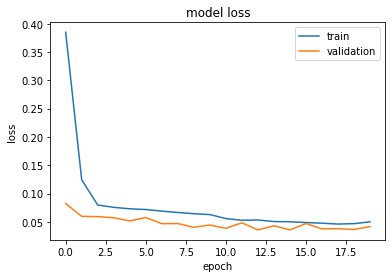

----------------------------------------
Prediction for batch size: 8, sequence lenght: 256
Accuracy:  0.9876302083333334
F1:  0.0


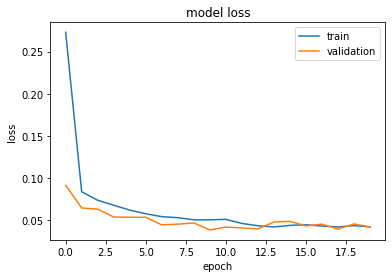

----------------------------------------
Prediction for batch size: 4, sequence lenght: 256
Accuracy:  0.9822823660714286
F1:  0.1360544217687075


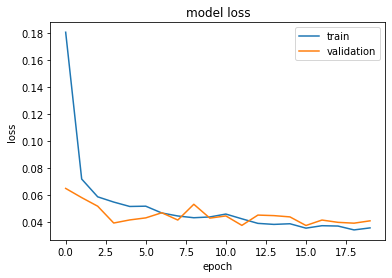

----------------------------------------
Prediction for batch size: 16, sequence lenght: 126
Accuracy:  0.9890873015873016
F1:  0.029411764705882353


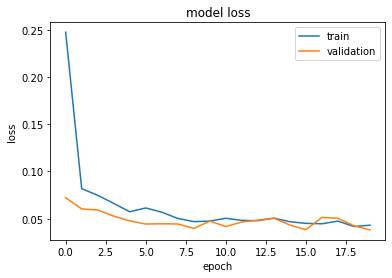

----------------------------------------
Prediction for batch size: 8, sequence lenght: 126
Accuracy:  0.981859410430839
F1:  0.058823529411764705


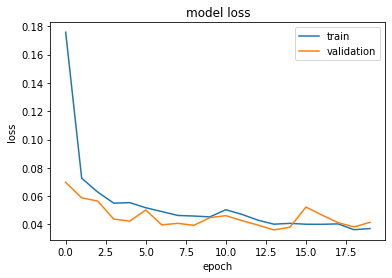

----------------------------------------
Prediction for batch size: 4, sequence lenght: 126
Accuracy:  0.9847883597883598
F1:  0.09448818897637795


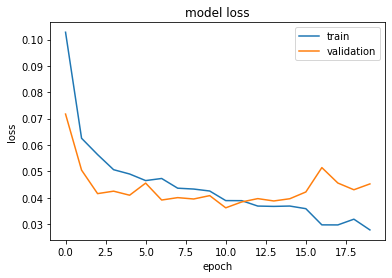

----------------------------------------
Prediction for batch size: 16, sequence lenght: 64
Accuracy:  0.98046875
F1:  0.07894736842105263


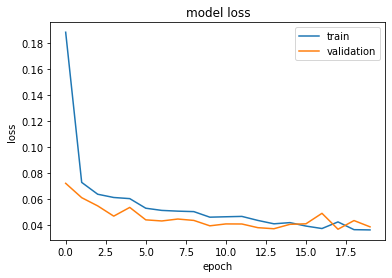

----------------------------------------
Prediction for batch size: 8, sequence lenght: 64
Accuracy:  0.9809895833333333
F1:  0.08750000000000001


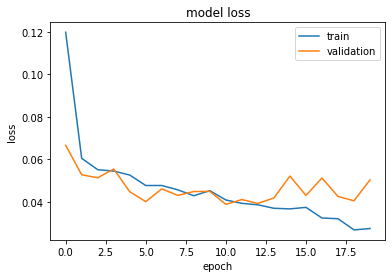

----------------------------------------
Prediction for batch size: 4, sequence lenght: 64
Accuracy:  0.9825520833333333
F1:  0.0821917808219178


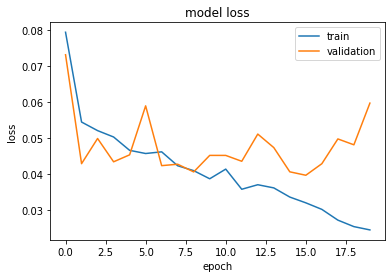

In [81]:
#we retrieve all the information from the files and plot the results in terms of accuracy and F1_score
import matplotlib.pyplot as plt


for filename in os.listdir(high_pred_path):
  if (filename.split('.')[0].split('_')[-1]) != 'loss': 
    print('----------------------------------------')
    tmp_pred = np.load(os.path.join(high_pred_path, filename))
    hist_path_loss = filename.split('.')[0] + '_hist_loss.npy'
    hist_path_val_loss = filename.split('.')[0] + '_hist_val_loss.npy'
    pred_path = filename.split('.')[0] + '_lab.npy'
    tmp_hist_loss = np.load(os.path.join(high_pred_path, hist_path_loss))
    tmp_hist_val_loss = np.load(os.path.join(high_pred_path, hist_path_val_loss))
    #tresholding
    tmp_pred_re = reshape_3Dto2D(tmp_pred) > 0.7
    sed_gt = np.load(os.path.join(high_pred_lab_path, pred_path))
    
    print("Prediction for batch size: {}, sequence lenght: {}".format(filename.split('_')[1], filename.split('_')[2].split('.')[0]))

    accuracy = accuracy_score(sed_gt, tmp_pred_re)
    print("Accuracy: ", accuracy)

    f1 = f1_score(sed_gt, tmp_pred_re, zero_division=1)
    print("F1: ", f1)


    # summarize history for loss
    plt.plot(tmp_hist_loss)
    plt.plot(tmp_hist_val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

----------------------------------------
Prediction for batch size: 16, sequence lenght: 256
[[4091    5]
 [   0    0]]


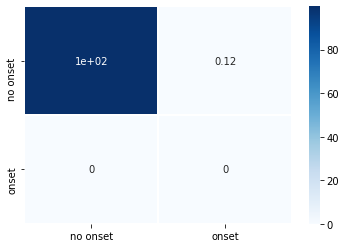

----------------------------------------
Prediction for batch size: 8, sequence lenght: 256
[[6068    4]
 [  72    0]]


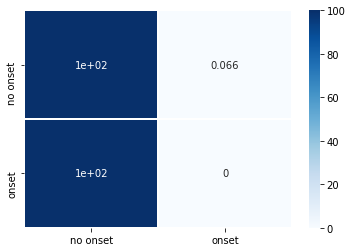

----------------------------------------
Prediction for batch size: 4, sequence lenght: 256
[[7031   37]
 [  90   10]]


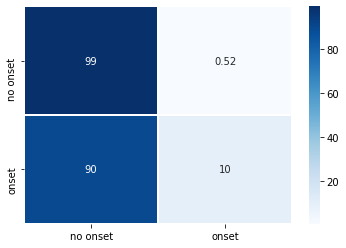

----------------------------------------
Prediction for batch size: 16, sequence lenght: 126
[[5981    3]
 [  63    1]]


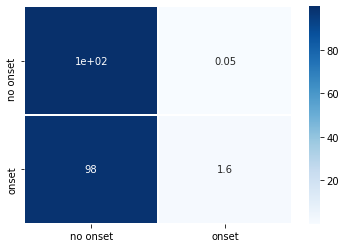

----------------------------------------
Prediction for batch size: 8, sequence lenght: 126
[[6924   36]
 [  92    4]]


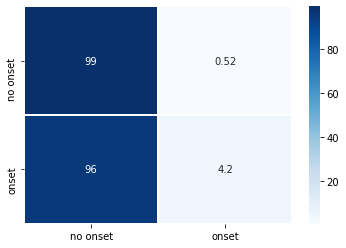

----------------------------------------
Prediction for batch size: 4, sequence lenght: 126
[[7439   21]
 [  94    6]]


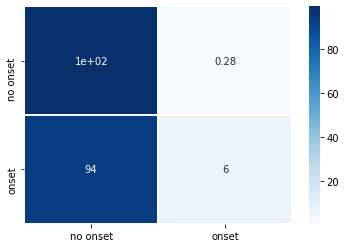

----------------------------------------
Prediction for batch size: 16, sequence lenght: 64
[[7022   34]
 [ 106    6]]


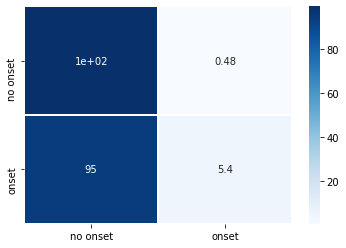

----------------------------------------
Prediction for batch size: 8, sequence lenght: 64
[[7527   57]
 [  89    7]]


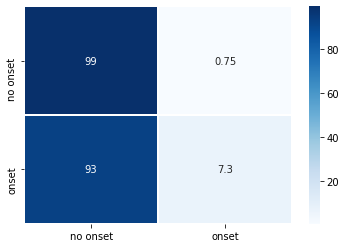

----------------------------------------
Prediction for batch size: 4, sequence lenght: 64
[[7540   32]
 [ 102    6]]


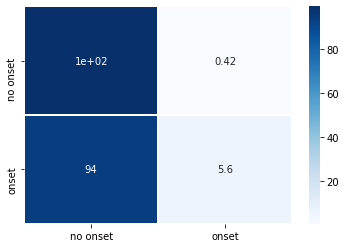

In [82]:
#we retrieve all the information from the files and plot the confusiuon matrices
import matplotlib.pyplot as plt


for filename in os.listdir(high_pred_path):
  if (filename.split('.')[0].split('_')[-1]) != 'loss': 
    print('----------------------------------------')
    tmp_pred = np.load(os.path.join(high_pred_path, filename))
    hist_path_loss = filename.split('.')[0] + '_hist_loss.npy'
    hist_path_val_loss = filename.split('.')[0] + '_hist_val_loss.npy'
    pred_path = filename.split('.')[0] + '_lab.npy'
    tmp_hist_loss = np.load(os.path.join(high_pred_path, hist_path_loss))
    tmp_hist_val_loss = np.load(os.path.join(high_pred_path, hist_path_val_loss))
    #tresholding
    tmp_pred_re = reshape_3Dto2D(tmp_pred) > 0.7
    sed_gt = np.load(os.path.join(high_pred_lab_path, pred_path))
  

    print("Prediction for batch size: {}, sequence lenght: {}".format(filename.split('_')[1], filename.split('_')[2].split('.')[0]))


    matrix_test = confusion_matrix(sed_gt, tmp_pred_re)
    print(matrix_test) 

    matrix_test_norm = confusion_matrix(sed_gt, tmp_pred_re, normalize='true') * 100 

    ax = sns.heatmap(matrix_test_norm, linewidth=0.5, annot=True, cmap="Blues", xticklabels= ['no onset', 'onset'], yticklabels= ['no onset','onset'])
    plt.show()   

## Wide CRNN architecture, kernel filter size 6X2 


In [0]:
wide_pred_path = prediction_folder + 'wide_pred'
wide_pred_lab_path = label_for_prediction_folder + 'wide_pred_lab'
create_folder(wide_pred_path)
create_folder(wide_pred_lab_path)

In [0]:
from numpy.random import seed
seed(1)
import tensorflow as ts
from tensorflow.keras.layers import Bidirectional, Conv2D, MaxPool2D, Input, MaxPooling3D, Conv3D
from tensorflow.keras.layers import Dense, Activation, Dropout, Reshape, Permute
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.optimizers import Adam

ts.keras.backend.set_image_data_format('channels_last')

def get_model_wide(data_in, data_out, dropout_rate, nb_cnn2d_filt, pool_size,
              rnn_size, fnn_size, weights, first):

    #initial dimenison set for channel last
    spec_start = Input(shape=(data_in[2], data_in[3], data_in[1]))
    #dimension for cnn same as the starting point
    spec_cnn = spec_start
    for i, convCount in enumerate(pool_size):
        #convolutional layer - wide filkter size
        spec_cnn = Conv2D(filters=nb_cnn2d_filt, kernel_size=(2, 6), padding='same')(spec_cnn)
        spec_cnn = BatchNormalization(trainable=True)(spec_cnn, training=True)
        spec_cnn = Activation('relu')(spec_cnn)
        spec_cnn = MaxPool2D(pool_size=(1, pool_size[i]))(spec_cnn)

    #reshape to a proper dimension for recurrent layers
    spec_rnn = Reshape((data_in[2], 2*nb_cnn2d_filt))(spec_cnn)

    for nb_rnn_filt in rnn_size:
        spec_rnn = Bidirectional(
            GRU(nb_rnn_filt, activation='tanh', dropout=dropout_rate, recurrent_dropout=dropout_rate,
                return_sequences=True, reset_after=False), 
            merge_mode='mul'
        )(spec_rnn, training=True)

    #FC
    sed = spec_rnn
    sed = TimeDistributed(Dense(fnn_size[0]))(sed)
    sed = TimeDistributed(Dense(data_out[-1]))(sed)
    sed = Activation('sigmoid', name='sed_out')(sed)

    model = Model(inputs=spec_start, outputs=[sed])
    model.compile(optimizer=Adam(), loss=['binary_crossentropy'], loss_weights=weights)

    if first:
      model.summary()
    return model

In [85]:
import numpy as np
from numpy.random import seed
seed(1)
import sys
import os
import time
import matplotlib.pyplot as plot
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# get all the parameters i need for the project
nb_epochs = 25 #if changed all the prediction need to be re-done so please delete the file inside the folders and start the code again. 
first = 1


#loop trough the different epochs, sequence lenghth and batch size:
for seq_lenght in [256, 126, 64]:
  for batch_size in [16, 8, 4]:
    
    params['sequence_length'] = seq_lenght
    params['batch_size'] = batch_size
    params['nb_epochs'] = nb_epochs
    
    print('-------------------------------------------')
    
    print("Batch size: ", batch_size)
    print("seq_lenght: ", seq_lenght)
    pred_filename = '/pred_{}_{}'.format(batch_size, seq_lenght) 
    if os.path.exists(os.path.join(wide_pred_path + pred_filename + '.npy')):
      print("Prediction for batch size {0} and seq lenght {1} with squared filters already done".format(batch_size, seq_lenght))
    else:

      print("Path to file: ", os.path.join(wide_pred_path + pred_filename))

      data_gen_train = DataGenerator(
          nfft=params['nfft'],
          batch_size=params['batch_size'], seq_len=params['sequence_length'], datagen_mode='train'
      )


    # generation of testing dataset
      data_gen_test = DataGenerator(
         nfft=params['nfft'],
         batch_size=params['batch_size'], seq_len=params['sequence_length'], datagen_mode='test', shuffle=False
      )

      data_in, data_out = data_gen_train.get_data_sizes()

      model = get_model_high(data_in=data_in, data_out=data_out, dropout_rate=params['dropout_rate'],
                  nb_cnn2d_filt=params['nb_cnn2d_filt'], pool_size=params['pool_size'],
                  rnn_size=params['rnn_size'], fnn_size=params['fnn_size'],
                  weights=params['loss_weights'], first=first)
    
      #so we do print the model only for the first case 
      first = 0

      gt = collect_test_labels(data_gen_test, data_out, params['quick_test'])
      #reshape to 2D
      sed_gt = reshape_3Dto2D(gt)
      file_path = os.path.join(wide_pred_lab_path + pred_filename + '_lab')
      print("File prediction saved: {}".format(file_path))
      np.save(file_path, sed_gt)
      print("File prediction saved: {}".format(file_path))

     # it returns an history value
      #model fit
      hist = model.fit(
          x=data_gen_train.generate(),
          steps_per_epoch=1 if params['quick_test'] else data_gen_train.get_total_batches_in_data(),
          validation_data=data_gen_test.generate(),
          validation_steps=1 if params['quick_test'] else data_gen_test.get_total_batches_in_data(),
          epochs=nb_epochs,
          verbose=1)



      #model prediction
      pred = model.predict(
          x=data_gen_test.generate(),
          steps=1 if params['quick_test'] else data_gen_test.get_total_batches_in_data(),
          verbose=0
      )

    
      #training loss values
      hist_loss_filename = os.path.join(wide_pred_path + pred_filename) + '_hist_loss'
      np.save(hist_loss_filename, hist.history['loss'])
      print("File prediction loss saved {}".format(os.path.join(wide_pred_path + hist_loss_filename)))
      #validation loss values
      hist_val_loss_filename = os.path.join(wide_pred_path + pred_filename) + '_hist_val_loss'
      np.save(hist_val_loss_filename, hist.history['val_loss'])
      print("File prediction val_loss saved {}".format(os.path.join(wide_pred_path + hist_val_loss_filename)))
      #predictions 
      np.save(os.path.join(wide_pred_path + pred_filename), pred)
      print("File prediction saved {}".format(os.path.join(wide_pred_path + pred_filename)))

-------------------------------------------
Batch size:  16
seq_lenght:  256
Prediction for batch size 16 and seq lenght 256 with squared filters already done
-------------------------------------------
Batch size:  8
seq_lenght:  256
Prediction for batch size 8 and seq lenght 256 with squared filters already done
-------------------------------------------
Batch size:  4
seq_lenght:  256
Prediction for batch size 4 and seq lenght 256 with squared filters already done
-------------------------------------------
Batch size:  16
seq_lenght:  126
Prediction for batch size 16 and seq lenght 126 with squared filters already done
-------------------------------------------
Batch size:  8
seq_lenght:  126
Prediction for batch size 8 and seq lenght 126 with squared filters already done
-------------------------------------------
Batch size:  4
seq_lenght:  126
Prediction for batch size 4 and seq lenght 126 with squared filters already done
-------------------------------------------
Batch size

## Evaluation wide CRNN architecture

Evaluation in terms of F1-score and accuracy 

----------------------------------------
Prediction for batch size: 16, sequence lenght: 256
Accuracy:  1.0
F1:  1.0


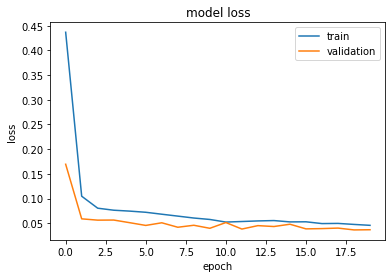

----------------------------------------
Prediction for batch size: 8, sequence lenght: 256
Accuracy:  0.9876302083333334
F1:  0.049999999999999996


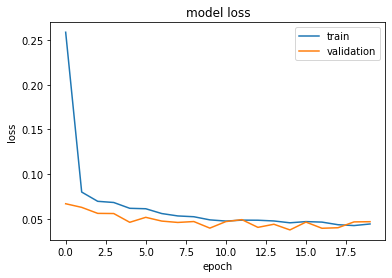

----------------------------------------
Prediction for batch size: 4, sequence lenght: 256
Accuracy:  0.9854910714285714
F1:  0.0


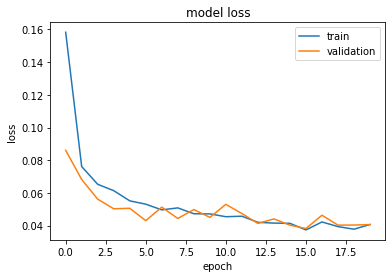

----------------------------------------
Prediction for batch size: 16, sequence lenght: 126
Accuracy:  0.9889219576719577
F1:  0.0


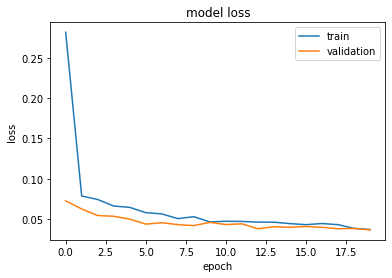

----------------------------------------
Prediction for batch size: 8, sequence lenght: 126
Accuracy:  0.9854024943310657
F1:  0.05504587155963303


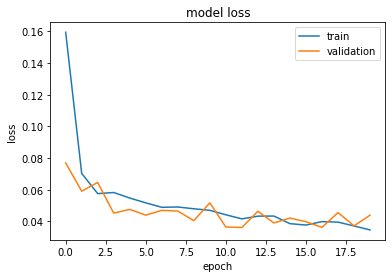

----------------------------------------
Prediction for batch size: 4, sequence lenght: 126
Accuracy:  0.9830687830687831
F1:  0.1232876712328767


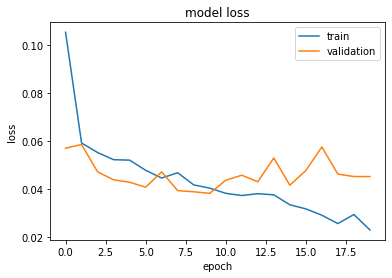

----------------------------------------
Prediction for batch size: 16, sequence lenght: 64
Accuracy:  0.9818638392857143
F1:  0.029850746268656716


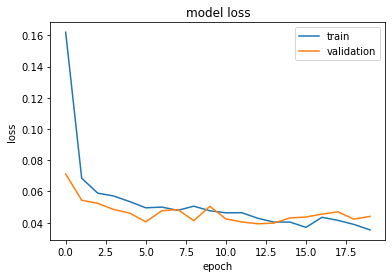

----------------------------------------
Prediction for batch size: 8, sequence lenght: 64
Accuracy:  0.9864583333333333
F1:  0.11864406779661017


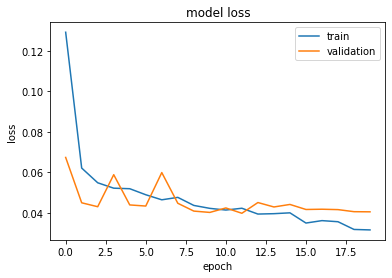

----------------------------------------
Prediction for batch size: 4, sequence lenght: 64
Accuracy:  0.9765625
F1:  0.08163265306122448


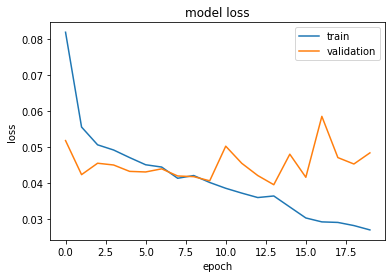

In [86]:
#we retrieve all the information from the files and print them in terms of accuracy and F1-score
import matplotlib.pyplot as plt


for filename in os.listdir(wide_pred_path):
  if (filename.split('.')[0].split('_')[-1]) != 'loss': 
    print('----------------------------------------')
    tmp_pred = np.load(os.path.join(wide_pred_path, filename))
    hist_path_loss = filename.split('.')[0] + '_hist_loss.npy'
    hist_path_val_loss = filename.split('.')[0] + '_hist_val_loss.npy'
    pred_path = filename.split('.')[0] + '_lab.npy'
    tmp_hist_loss = np.load(os.path.join(wide_pred_path, hist_path_loss))
    tmp_hist_val_loss = np.load(os.path.join(wide_pred_path, hist_path_val_loss))
    #thresholding
    tmp_pred_re = reshape_3Dto2D(tmp_pred) > 0.7
    sed_gt = np.load(os.path.join(wide_pred_lab_path, pred_path))
    
    print("Prediction for batch size: {}, sequence lenght: {}".format(filename.split('_')[1], filename.split('_')[2].split('.')[0]))

    accuracy = accuracy_score(sed_gt, tmp_pred_re)
    print("Accuracy: ", accuracy)

    f1 = f1_score(sed_gt, tmp_pred_re, zero_division=1)
    print("F1: ", f1)

    # summarize history for loss
    plt.plot(tmp_hist_loss)
    plt.plot(tmp_hist_val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

----------------------------------------
Prediction for batch size: 16, sequence lenght: 256
[[4096]]


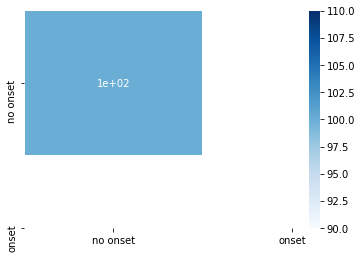

----------------------------------------
Prediction for batch size: 8, sequence lenght: 256
[[6066    6]
 [  70    2]]


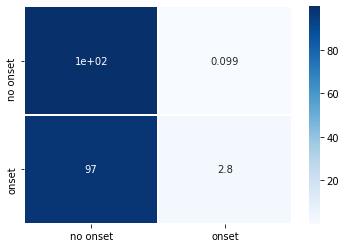

----------------------------------------
Prediction for batch size: 4, sequence lenght: 256
[[7064    4]
 [ 100    0]]


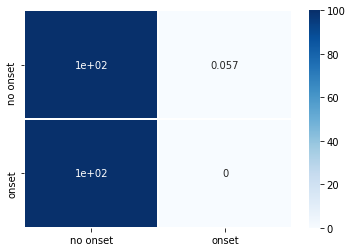

----------------------------------------
Prediction for batch size: 16, sequence lenght: 126
[[5981    3]
 [  64    0]]


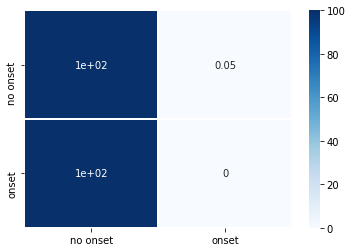

----------------------------------------
Prediction for batch size: 8, sequence lenght: 126
[[6950   10]
 [  93    3]]


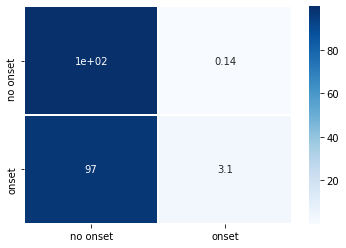

----------------------------------------
Prediction for batch size: 4, sequence lenght: 126
[[7423   37]
 [  91    9]]


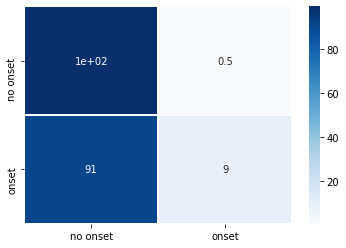

----------------------------------------
Prediction for batch size: 16, sequence lenght: 64
[[7036   20]
 [ 110    2]]


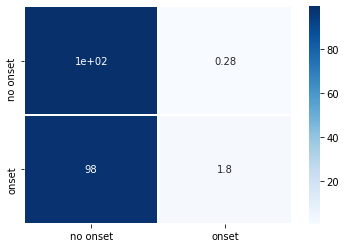

----------------------------------------
Prediction for batch size: 8, sequence lenght: 64
[[7569   15]
 [  89    7]]


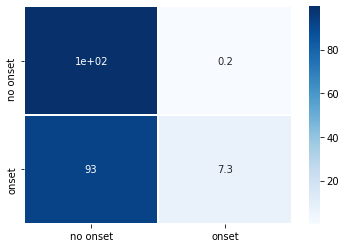

----------------------------------------
Prediction for batch size: 4, sequence lenght: 64
[[7492   80]
 [ 100    8]]


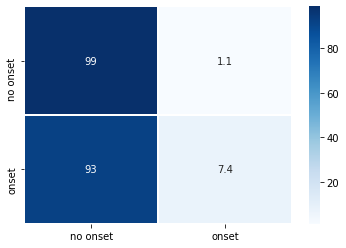

In [87]:
#we retrieve all the information from the files and plot the confusion matrices
import matplotlib.pyplot as plt


for filename in os.listdir(wide_pred_path):
  if (filename.split('.')[0].split('_')[-1]) != 'loss': 
    print('----------------------------------------')
    tmp_pred = np.load(os.path.join(wide_pred_path, filename))
    hist_path_loss = filename.split('.')[0] + '_hist_loss.npy'
    hist_path_val_loss = filename.split('.')[0] + '_hist_val_loss.npy'
    pred_path = filename.split('.')[0] + '_lab.npy'
    tmp_hist_loss = np.load(os.path.join(wide_pred_path, hist_path_loss))
    tmp_hist_val_loss = np.load(os.path.join(wide_pred_path, hist_path_val_loss))
    #tresholding
    tmp_pred_re = reshape_3Dto2D(tmp_pred) > 0.7
    sed_gt = np.load(os.path.join(wide_pred_lab_path, pred_path))
    

    print("Prediction for batch size: {}, sequence lenght: {}".format(filename.split('_')[1], filename.split('_')[2].split('.')[0]))

    matrix_test = confusion_matrix(sed_gt, tmp_pred_re)
    print(matrix_test) 

    matrix_test_norm = confusion_matrix(sed_gt, tmp_pred_re, normalize='true') * 100 

    ax = sns.heatmap(matrix_test_norm, linewidth=0.5, annot=True, cmap="Blues", xticklabels= ['no onset', 'onset'], yticklabels= ['no onset','onset'])
    plt.show()  

Comment and discussion regarding the results can be found on the report: LINK TO REPORT 